<a href="https://colab.research.google.com/github/Vaivaswat2244/Adobe-GenSolve/blob/main/Occlusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%mkdir Output

# **Occlusion**
The code performs shape detection and completion on input fragments. This process involves:
1.	CSV Parsing:
o	Read input CSV file containing polyline data.
o	Group points by path and sub path.
2.	Shape Detection:
o	For each polyline, detect the shape based on circularity and number of corners.
o	Shapes are categorized as circles, rectangles, triangles, pentagons, stars, or unknown.
3.	Shape Completion:
o	If a shape is detected as occluded (fewer points than expected), complete it.
o	Different completion methods for different shapes (e.g., circle, star).


In [11]:
import numpy as np
import cv2
import csv

def read_csv(csv_path):
    # Read CSV file and convert to numpy array
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    # Group points by path and subpath
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def detect_shape(contour):
    # Calculate circularity of the contour
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    circularity = (4 * np.pi * area) / (perimeter * perimeter) if perimeter > 0 else 0

    # Approximate the contour to simplify shape
    epsilon = 0.02 * perimeter
    approx = cv2.approxPolyDP(contour, epsilon, True)

    num_corners = len(approx)

    # Determine shape based on circularity and number of corners
    if circularity > 0.9:
        return "CIRCLE", approx
    elif circularity > 0.75 and 4 <= num_corners <= 6:
        return "RECTANGLE", approx
    elif 0.6 < circularity < 0.8 and 3 <= num_corners <= 4:
        return "TRIANGLE", approx
    elif 0.6 < circularity < 0.8 and 5 <= num_corners <= 6:
        return "PENTAGON", approx
    elif 0.4 < circularity < 0.6 and 8 <= num_corners <= 12:
        return "STAR", approx
    else:
        return "UNKNOWN", approx

def complete_shape(shape, vertices):
    if shape == "CIRCLE":
        # Complete circle using minimum enclosing circle
        (x, y), radius = cv2.minEnclosingCircle(vertices)
        center = (int(x), int(y))
        radius = int(radius)
        theta = np.linspace(0, 2*np.pi, 100)
        x = center[0] + radius * np.cos(theta)
        y = center[1] + radius * np.sin(theta)
        return np.column_stack((x, y))
    elif shape in ["RECTANGLE", "TRIANGLE", "PENTAGON"]:
        # Return vertices as is for these shapes
        return vertices
    elif shape == "STAR":
        # Complete star shape
        center = np.mean(vertices, axis=0)
        angles = np.linspace(0, 2*np.pi, 11)[:-1]
        radii = [np.linalg.norm(v - center) for v in vertices]
        avg_radius = np.mean(radii)
        inner_radius = avg_radius * 0.4
        star_points = []
        for i, angle in enumerate(angles):
            radius = avg_radius if i % 2 == 0 else inner_radius
            x = center[0] + radius * np.cos(angle)
            y = center[1] + radius * np.sin(angle)
            star_points.append([x, y])
        return np.array(star_points)
    else:
        # Return vertices as is for unknown shapes
        return vertices

def process_shapes(csv_path):
    polylines = read_csv(csv_path)
    completed_polylines = []

    for polyline in polylines:
        contour = np.concatenate(polyline).astype(np.int32)

        # Detect shape
        shape, vertices = detect_shape(contour)

        # Check if shape is occluded
        is_occluded = len(contour) < len(vertices)

        if is_occluded:
            # Complete shape if occluded
            completed_shape = complete_shape(shape, vertices)
            completed_polylines.append(completed_shape)
        else:
            # If not occluded, keep original polyline
            completed_polylines.append(contour)

    return completed_polylines

def write_csv(polylines, output_path):
    # Write completed polylines to CSV file
    with open(output_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        for i, polyline in enumerate(polylines):
            for point in polyline:
                row = [i, i] + list(point)
                writer.writerow(row)

# Main execution
input_csv_path = '/content/drive/MyDrive/Input/problems/occlusion1.csv' #Enter csv file's Path
input_csv_name = input_csv_path.split("/")[-1].split(".")[0]
output_csv_path = '/content/Output/completed_polylines_{}.csv'.format(input_csv_name)

# Process shapes and write results to CSV
result_polylines = process_shapes(input_csv_path)
write_csv(result_polylines, output_csv_path)

print(f"Completed polylines have been written to {output_csv_path}")

Completed polylines have been written to /content/Output/completed_polylines_occlusion1.csv


'completed_polylines_occlusion1.png'

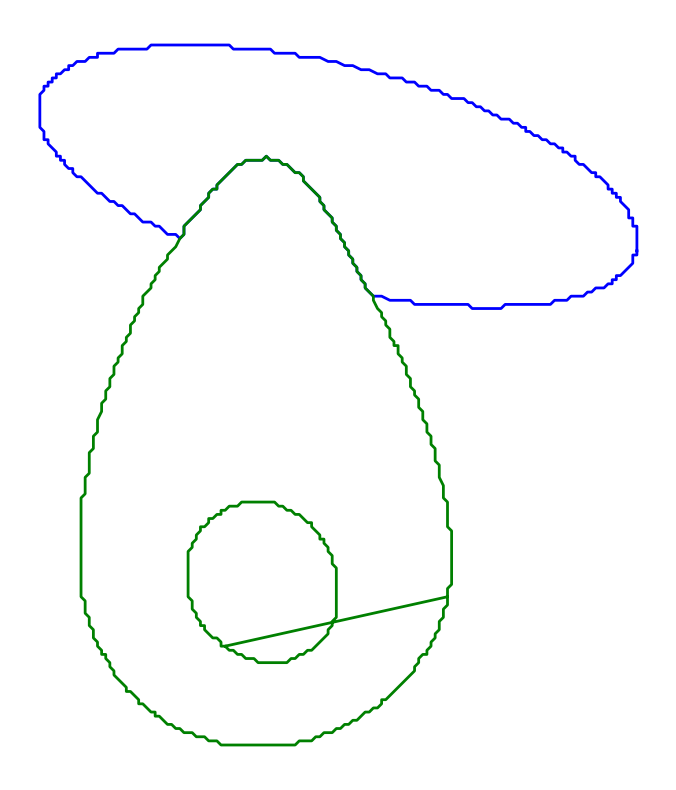

In [12]:
import matplotlib.pyplot as plt
def plot(csv_path):
    paths_XYs=read_csv(csv_path)
    file_name = csv_path.split("/")[-1]
    savepath = '{}.png'.format(file_name.split(".")[0])
    colours = ['b', 'g', 'r', 'c', 'y', 'k']
    fig, ax = plt.subplots(tight_layout=True, figsize =(8, 8))
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth =2)

    ax.set_aspect('equal')
    ax.axis('off')  # Turn off the axis
    plt.savefig(savepath, bbox_inches='tight', pad_inches=0)
    # plt.show()
    return  savepath

plot('/content/Output/completed_polylines_{}.csv'.format(input_csv_name))

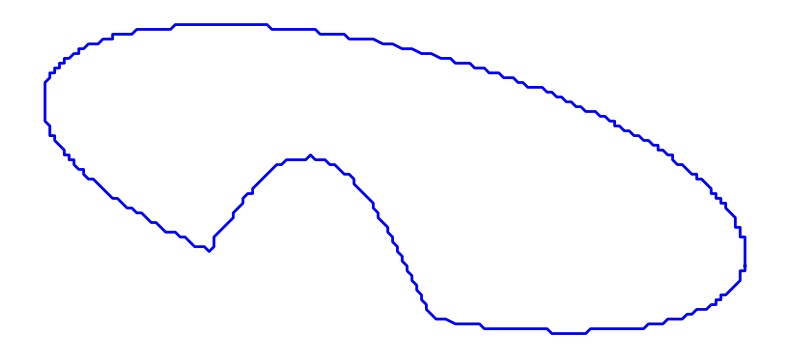

Polyline saved as completed_polylines_occlusion1_0_occlusion1.png


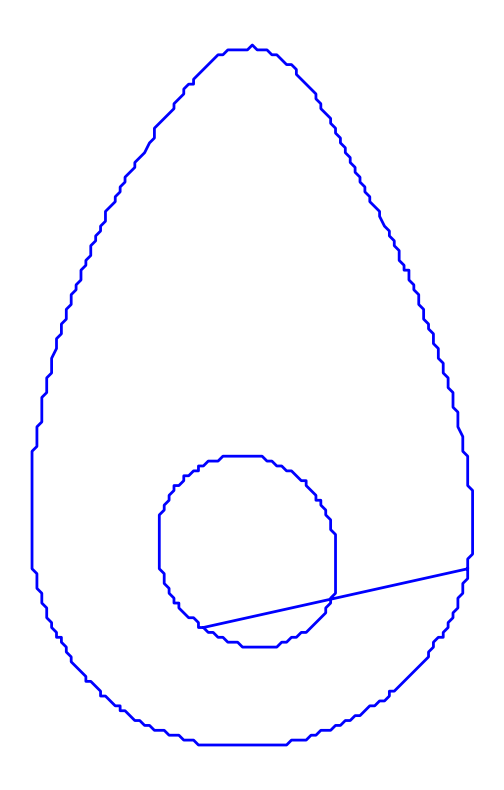

Polyline saved as completed_polylines_occlusion1_1_occlusion1.png


In [13]:
import matplotlib.pyplot as plt

def plot_single_polyline(csv_path, polyline_index):
    paths_XYs = read_csv(csv_path)
    file_name = csv_path.split("/")[-1]
    savepath = f'{file_name.split(".")[0]}_{polyline_index}_{input_csv_name}.png'

    if polyline_index < 0 or polyline_index >= len(paths_XYs):
        print(f"Error: Polyline index {polyline_index} is out of range. There are {len(paths_XYs)} polylines.")
        return None

    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))

    XYs = paths_XYs[polyline_index]
    for XY in XYs:
        ax.plot(XY[:, 0], XY[:, 1], c='b', linewidth=2)

    ax.set_aspect('equal')
    ax.axis('off')  # Turn off the axis
    plt.savefig(savepath, bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close(fig)  # Close the figure to free up memory

    return savepath

# Example usage
csv_path = '/content/Output/completed_polylines_{}.csv'.format(input_csv_name)
polylinrs= read_csv(csv_path)
for i in range(len(polylinrs)):
    result = plot_single_polyline(csv_path, i)
    if result:
      print(f"Polyline saved as {result}")
    else:
      print("Invalid polyline index. Please provide a valid index.")